In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [104]:
# Load preprocessed DataFrame
df = pd.read_csv("/kaggle/input/sign-language-pre-processed-for-27-words/sign_27.csv")

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32865 entries, 0 to 32864
Columns: 1665 entries, action to kp_1661
dtypes: float64(1662), int64(1), object(2)
memory usage: 417.5+ MB


In [106]:
df.head(2)

,action,video,frame,kp_0,kp_1,kp_2,kp_3,kp_4,kp_5,kp_6,...,kp_1652,kp_1653,kp_1654,kp_1655,kp_1656,kp_1657,kp_1658,kp_1659,kp_1660,kp_1661
0,good night,MVI_005_6.MOV,0,0.489297,0.146612,-0.502261,0.999895,0.499013,0.123582,-0.481440,...,-0.001275,0.409427,0.832730,-0.003213,0.417676,0.843267,-0.002958,0.424856,0.848169,-0.002093
1,good night,MVI_005_6.MOV,1,0.488763,0.148646,-0.501405,0.999897,0.498282,0.124194,-0.481308,...,-0.001907,0.409393,0.834686,-0.004285,0.417800,0.844495,-0.004322,0.424833,0.848541,-0.003665


In [107]:
df.head(2)

,action,video,frame,kp_0,kp_1,kp_2,kp_3,kp_4,kp_5,kp_6,...,kp_1652,kp_1653,kp_1654,kp_1655,kp_1656,kp_1657,kp_1658,kp_1659,kp_1660,kp_1661
0,good night,MVI_005_6.MOV,0,0.489297,0.146612,-0.502261,0.999895,0.499013,0.123582,-0.481440,...,-0.001275,0.409427,0.832730,-0.003213,0.417676,0.843267,-0.002958,0.424856,0.848169,-0.002093
1,good night,MVI_005_6.MOV,1,0.488763,0.148646,-0.501405,0.999897,0.498282,0.124194,-0.481308,...,-0.001907,0.409393,0.834686,-0.004285,0.417800,0.844495,-0.004322,0.424833,0.848541,-0.003665


## baisc pre-processing:-

# RESSON

### **📌 Summary: Frame Processing for Video Sequences**  

#### **🎯 Goal:**  
Ensure all videos have exactly **35 frames or any desired 35 because mean frmaes per video is 34** for consistency in deep learning models (e.g., LSTMs, CNNs).  

#### **📌 Approach:**  
1. **For videos with more than 35 frames:**  
   - Trim the **middle 35 frames**, removing an equal number of frames from the **start and end** to **preserve the most relevant motion**.  

2. **For videos with fewer than 35 frames:**  
   - **Interpolate** additional frames instead of duplicating them, ensuring smooth transitions.  
   - This avoids abrupt jumps in motion, improving model learning.  

#### **🛠️ Interpolation Methods Used:**  
- **Linear Interpolation:** Predicts intermediate frames based on a straight-line change.  
- **Cubic/Spline Interpolation:** Provides **smoother** transitions, reducing unnatural movement.  

#### **🚀 Why Interpolation Instead of Duplication?**  
✅ Prevents **static frames** that could mislead the model.  
✅ Ensures **natural motion** instead of abrupt jumps.  
✅ Helps models like LSTMs and CNNs learn better **temporal patterns**.  

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_frame_distribution(frame_counts):
    """
    Plots histogram, boxplot, and CDF to analyze the distribution of frames per video.
    
    Args:
        frame_counts (pd.Series): Series containing the frame count for each video.
    """
    plt.figure(figsize=(15, 5))
    
    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(frame_counts, bins=30, kde=True, color="blue")
    plt.axvline(frame_counts.median(), color='red', linestyle='dashed', label=f"Median: {frame_counts.median()}")
    plt.axvline(frame_counts.mean(), color='green', linestyle='dashed', label=f"Mean: {frame_counts.mean():.2f}")
    plt.legend()
    plt.xlabel("Number of Frames per Video")
    plt.ylabel("Frequency")
    plt.title("Histogram of Frame Counts")

    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=frame_counts, color="orange")
    plt.xlabel("Number of Frames per Video")
    plt.title("Boxplot of Frame Counts")

    # CDF Plot
    plt.subplot(1, 3, 3)
    sns.ecdfplot(frame_counts, color="purple")
    plt.axhline(0.9, color='red', linestyle='dashed', label="90% Coverage")
    plt.legend()
    plt.xlabel("Number of Frames per Video")
    plt.ylabel("Cumulative Probability")
    plt.title("CDF of Frame Counts")

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


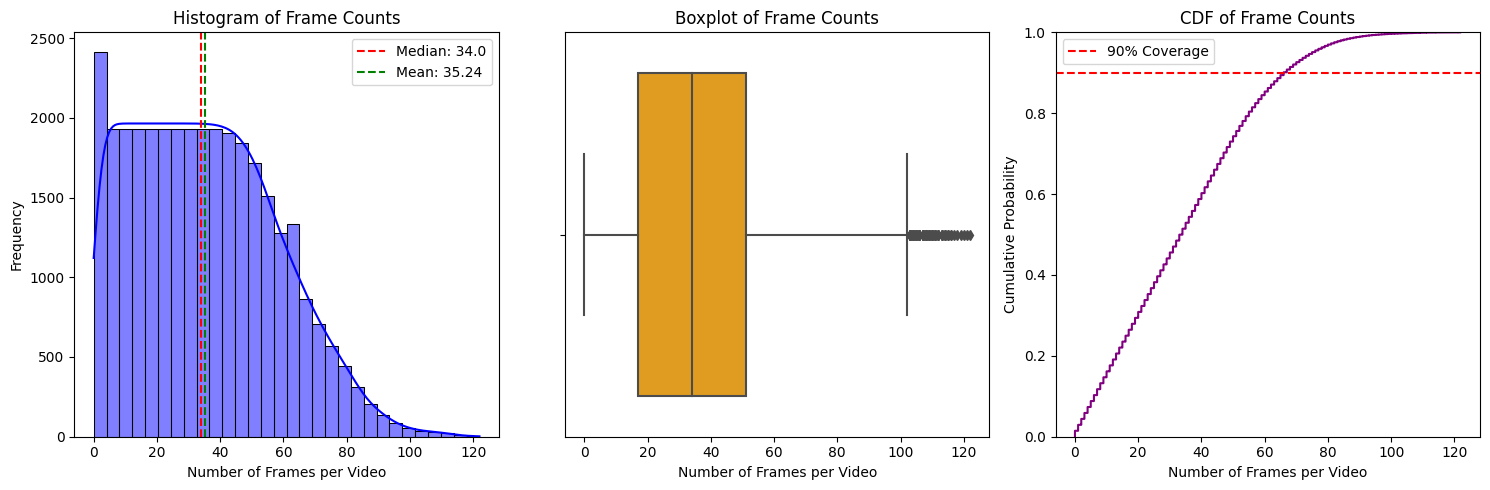

In [109]:
plot_frame_distribution(df["frame"])

In [110]:
df['frame'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122])

In [111]:
frame_count = df.groupby('video')['frame'].count()
print(frame_count)
print(f'max value:- ', frame_count.max())
print(f'min value:- ', frame_count.min())
print(frame_count.unique())

video
MVI_0001.MOV    55
MVI_0002.MOV    56
MVI_0003.MOV    60
MVI_0004.MOV    60
MVI_0006.MOV    53
                ..
MVI_9994.MOV    55
MVI_9995.MOV    63
MVI_9996.MOV    60
MVI_9998.MOV    54
MVI_9999.MOV    56
Name: frame, Length: 454, dtype: int64
max value:-  153
min value:-  36
[ 55  56  60  53  57  54  63  74  65  61  81  92  96  95 122 140 131  71
 151 139 143 153 146 128  87  90  64 141  62  91 149  84  89  82 137 130
 142  79  76  68  69  80  83 100  66  73  75  72  77 117  67  94 112  85
  99  97 103  88  86  98 104  78 109 123  93  70  59 116  44  40  48  51
 111 115 105 101  50  52  45  58  49  46  47  42  41  36  43 135 120 108
 134 138 124 125]


In [257]:
import numpy as np
import pandas as pd

def trim_and_pad_frames(df, target_frames=35):
    """
    Processes a DataFrame containing keypoint data for multiple videos.

    1. Removes videos with more than 40 frames.
    2. If a video has more than `target_frames` but ≤ 40 frames, it trims the last extra frames.
    3. If a video has fewer than `target_frames`, it pads with zero rows.

    Parameters:
        df (pd.DataFrame): DataFrame with 'action', 'video', 'frame' columns + keypoint columns.
        target_frames (int): Desired number of frames per video.

    Returns:
        pd.DataFrame: Processed DataFrame with exactly `target_frames` frames per video.
    """
    new_data = []

    for video_name, video_df in df.groupby("video"):
        num_frames = len(video_df)

        # Skip videos with more than 40 frames
        if num_frames > 40:
            continue  # Discard the video

        # If frames exceed target, trim the last extra frames
        elif num_frames > target_frames:
            video_df = video_df.iloc[:target_frames]  # Keep only the first `target_frames` frames

        # If frames are less than target, pad with zero rows
        elif num_frames < target_frames:
            keypoint_columns = video_df.drop(columns=["action", "video", "frame"]).columns
            padding_needed = target_frames - num_frames
            
            # Create zero-padded rows
            zero_padding = pd.DataFrame(np.zeros((padding_needed, len(keypoint_columns))), columns=keypoint_columns)
            zero_padding.insert(0, "video", video_name)
            zero_padding.insert(1, "frame", np.arange(num_frames + 1, target_frames + 1))  # New frame numbers
            zero_padding["action"] = video_df["action"].iloc[0]  # Maintain same action label
            
            video_df = pd.concat([video_df, zero_padding], ignore_index=True)

        # Ensure exactly `target_frames` per video
        assert len(video_df) == target_frames, f"Video {video_name} has {len(video_df)} frames, expected {target_frames}"

        new_data.append(video_df)

    return pd.concat(new_data, ignore_index=True)

In [258]:
df.columns

Index(['action', 'video', 'frame', 'kp_0', 'kp_1', 'kp_2', 'kp_3', 'kp_4',
       'kp_5', 'kp_6',
       ...
       'kp_1652', 'kp_1653', 'kp_1654', 'kp_1655', 'kp_1656', 'kp_1657',
       'kp_1658', 'kp_1659', 'kp_1660', 'kp_1661'],
      dtype='object', length=1665)

In [259]:
df.head(1)

,action,video,frame,kp_0,kp_1,kp_2,kp_3,kp_4,kp_5,kp_6,...,kp_1652,kp_1653,kp_1654,kp_1655,kp_1656,kp_1657,kp_1658,kp_1659,kp_1660,kp_1661
0,good night,MVI_005_6.MOV,0,0.489297,0.146612,-0.502261,0.999895,0.499013,0.123582,-0.48144,...,-0.001275,0.409427,0.83273,-0.003213,0.417676,0.843267,-0.002958,0.424856,0.848169,-0.002093


In [260]:
# df[df['video'] == 'MVI_0001.MOV']

In [263]:
df_trimmed = trim_and_interpolate_frames(df, target_frames=34)

In [264]:
df_trimmed.groupby("video")["frame"].count().unique()

array([34])

## Build and Train LSTM Neural Network:-

In [281]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

In [282]:
sequences, labels = [], []

# Ensure label_map is correctly defined
unique_actions = df_trimmed['action'].unique()
label_map = {action: i for i, action in enumerate(unique_actions)}

# Grouping videos
grouped = df_trimmed.groupby("video")

for video, group in grouped:
    group = group.sort_values('frame')  # Sort frames correctly
    keypoints_seq = group.iloc[:, 3:].values  # Extract only keypoints

    # Extract action from the group
    action = group['action'].iloc[0]  # Take first row (since all rows have the same action)
    
    sequences.append(keypoints_seq)
    labels.append(label_map[action])  # Convert action to label

In [320]:
reverse_label_map = {i: action for action, i in label_map.items()}
reverse_label_map

{0: 'good evening',
 1: 'good night',
 2: 'thank you',
 3: 'pleased',
 4: 'hello',
 5: 'how are you',
 6: 'alright',
 7: 'good morning',
 8: 'good afternoon',
 9: 'dog',
 10: 'cat',
 11: 'fish',
 12: 'bird',
 13: 'cow',
 14: 'extra',
 15: 'hat',
 16: 'dress',
 17: 'suit',
 18: 'skirt',
 19: 'shirt',
 20: 'loud',
 21: 'quiet',
 22: 'happy',
 23: 'sad',
 24: 'beautiful',
 25: 'ugly',
 26: 'deaf',
 27: 'blind'}

In [304]:
label_map

{'good evening': 0,
 'good night': 1,
 'thank you': 2,
 'pleased': 3,
 'hello': 4,
 'how are you': 5,
 'alright': 6,
 'good morning': 7,
 'good afternoon': 8,
 'dog': 9,
 'cat': 10,
 'fish': 11,
 'bird': 12,
 'cow': 13,
 'extra': 14,
 'hat': 15,
 'dress': 16,
 'suit': 17,
 'skirt': 18,
 'shirt': 19,
 'loud': 20,
 'quiet': 21,
 'happy': 22,
 'sad': 23,
 'beautiful': 24,
 'ugly': 25,
 'deaf': 26,
 'blind': 27}

In [283]:
# Convert to numpy arrays
X = np.array(sequences)
labels = np.array(labels)

# Convert labels to one-hot encoding
y = to_categorical(labels).astype(int)

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [299]:
model = Sequential([
    Input(shape=(35, X.shape[2])),  # (timesteps, features)
    
    LSTM(256, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='softmax')  # Output layer
])

In [300]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

In [302]:
# Callbacks for better training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

In [303]:
# Train model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=50, batch_size=16,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - categorical_accuracy: 0.0372 - loss: 3.4423 - val_categorical_accuracy: 0.0435 - val_loss: 3.3383 - learning_rate: 5.0000e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - categorical_accuracy: 0.0690 - loss: 3.2722 - val_categorical_accuracy: 0.0000e+00 - val_loss: 3.3206 - learning_rate: 5.0000e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - categorical_accuracy: 0.0772 - loss: 3.1090 - val_categorical_accuracy: 0.0000e+00 - val_loss: 3.3000 - learning_rate: 5.0000e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - categorical_accuracy: 0.0992 - loss: 2.9854 - val_categorical_accuracy: 0.0435 - val_loss: 3.2433 - learning_rate: 5.0000e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - categorical_accuracy: 0.1515 - loss: 2.8019 - val_categorical_accuracy: 0.0435 - val_loss: 3.3226 - learning_rate: 5.0000e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - categorical_accuracy: 0.2048 - loss: 

In [293]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 35, 128)             │         916,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 35, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 35, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 35, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 35, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 35, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 35, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 28)                  │             924 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,416,054 (13.03 MB)

 Trainable params: 1,138,556 (4.34 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 2,277,114 (8.69 MB)

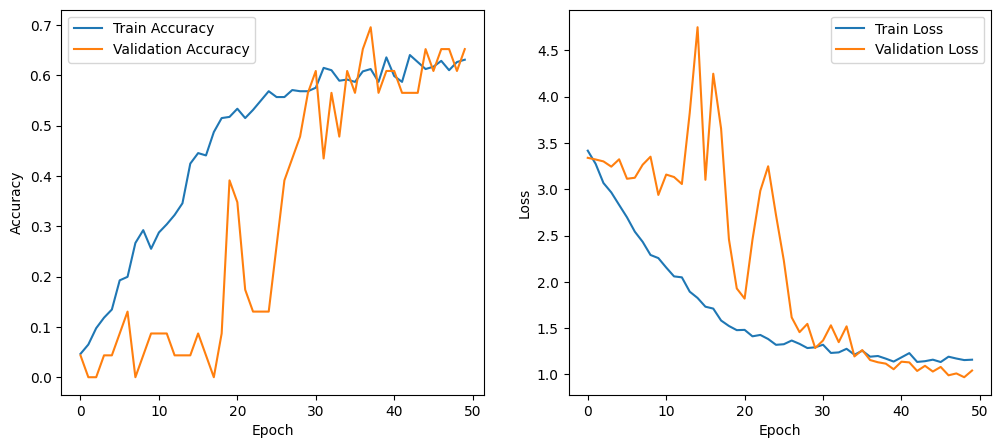

In [305]:
# Plot Accuracy & Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## model predictions:-

In [306]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


In [308]:
actions[np.argmax(res[0])]

'sad'

## Saving the model:-

In [309]:
model.save('1-> more than 60% accuracy model.keras')

In [70]:
model

<Sequential name=sequential_2, built=True>

In [71]:
del model

In [75]:
model = load_model('/kaggle/working/sl_sign.keras')

## Evaluating using Confusion Matrix and Accuracy:-

In [313]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [310]:
yhat = model.predict(X_train)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


In [311]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [314]:
accuracy_score(ytrue, yhat)

0.7192575406032483

In [317]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[378,  34],
        [  3,  16]],

       [[415,   0],
        [ 15,   1]],

       [[410,   5],
        [  1,  15]],

       [[422,   0],
        [  9,   0]],

       [[403,   8],
        [  7,  13]],

       [[409,   1],
        [  5,  16]],

       [[404,  10],
        [  5,  12]],

       [[410,   7],
        [  8,   6]],

       [[406,   4],
        [ 17,   4]],

       [[412,   2],
        [  1,  16]],

       [[412,   3],
        [  0,  16]],

       [[412,   1],
        [  4,  14]],

       [[410,   3],
        [  1,  17]],

       [[413,   0],
        [  0,  18]],

       [[425,   0],
        [  3,   3]],

       [[414,   0],
        [  3,  14]],

       [[412,   1],
        [ 17,   1]],

       [[413,   0],
        [  0,  18]],

       [[412,   2],
        [  0,  17]],

       [[411,   2],
        [  0,  18]],

       [[410,   1],
        [  0,  20]],

       [[400,  11],
        [  0,  20]],

       [[412,   0],
        [  2,  17]],

       [[418,   6],
        [  0, 

In [318]:
accuracy_score(ytrue, yhat)

0.7192575406032483